In [2]:
%matplotlib widget
# %matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
import bmcs_utils.api as bu
from bmcs_cross_section.api import *
from bmcs_beam.api import *
from mpl_toolkits import mplot3d

In [3]:
b_sls = BeamSLSCurve(f_ck = 90, b=300, h=100, high_kappa=0.0002, rein_type = 'carbon_grid', system_type = 'dist', n_i=9, dense_quarter=True)
# b_sls = BeamSLSCurve(f_ck = 70, rein_type = 'steel', system_type = 'dist', n_i=16) 
b_sls.interact()

dp updated!
dp updated!
dp updated!
dp updated!
V_Rm_c = 64.97 kN, Shear failure by F_tot_max = 129.94 kN


<lambdifygenerated-26>:2: RuntimeWarning: invalid value encountered in power
  return -select([less(eps, varepsilon_cu),less(eps, varepsilon_cy),less(eps, 0),less(eps, varepsilon_cr),less(eps, varepsilon_tu),True], [0,f_cd,f_cd*(1 - (-eps/varepsilon_cy + 1)**n),-E_ct*eps,-E_ct*mu*varepsilon_cr,0], default=nan)


V_Rm_c = 64.97 kN, Shear failure by F_tot_max = 129.94 kN


In [3]:
b_sls.run()

run started...
parameter combination 0.0002 3.0
parameter combination 0.0002 5.9375
parameter combination 0.0002 8.875
parameter combination 0.0002 11.8125
parameter combination 0.0002 14.75
parameter combination 0.0002 23.5625
parameter combination 0.0002 32.375
parameter combination 0.0002 41.1875
parameter combination 0.0002 50.0
parameter combination 0.0017500000000000003 3.0
parameter combination 0.0017500000000000003 5.9375
parameter combination 0.0017500000000000003 8.875
parameter combination 0.0017500000000000003 11.8125
parameter combination 0.0017500000000000003 14.75
parameter combination 0.0017500000000000003 23.5625
parameter combination 0.0017500000000000003 32.375
parameter combination 0.0017500000000000003 41.1875
parameter combination 0.0017500000000000003 50.0
parameter combination 0.0033000000000000004 3.0
parameter combination 0.0033000000000000004 5.9375
parameter combination 0.0033000000000000004 8.875
parameter combination 0.0033000000000000004 11.8125
parameter

In [6]:
fig.savefig('x2.pdf')

V_Rm_c = 64.97 kN, Shear failure by F_tot_max = 129.94 kN
V_Rm_c = 64.97 kN, Shear failure by F_tot_max = 129.94 kN


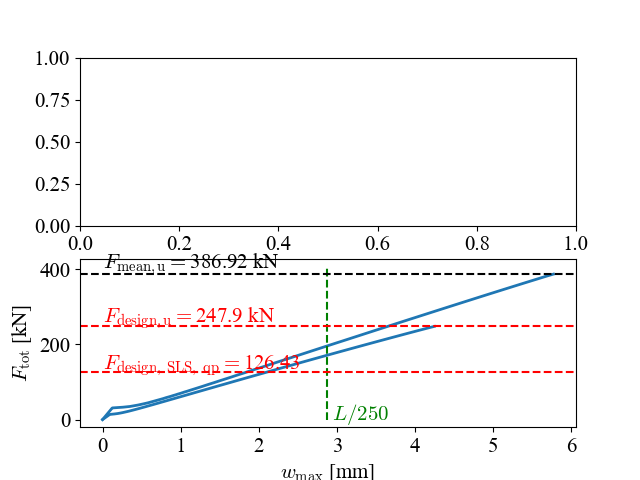

In [4]:
fig, axes = plt.subplots(2, 1)
b_sls.update_plot(axes)
fig.show()

In [10]:
# Get F_Ed and M_Ed according to EC2
b = b_sls.dp.mc.cross_section_shape_.B
h = b_sls.dp.mc.cross_section_shape_.H
L = b_sls.dp.beam_design.system_.L
reinf = list(b_sls.dp.mc.cross_section_layout.items.values())[0]
d = h - reinf.z
As = reinf.A
M_Ed, need_comp_reinf = EC2.get_M_Ed(b, d, As, b_sls.f_ck, 500)
F_Ed = (8 * M_Ed / L**2) * L # q*l
F_Ed/1000, M_Ed/10**6, need_comp_reinf

(115.0552200118607, 120.05916847826086, False)

$$\frac{F_\mathrm{limit}}{F_\mathrm{SLS}} = 1$$

$$\frac{F_\mathrm{limit}}{\eta F_\mathrm{ULS}} = 1$$

$$\frac{\eta F_\mathrm{ULS}}{F_\mathrm{limit}}= 1$$

$$\frac{F_\mathrm{ULS}}{F_\mathrm{limit}}= \frac{1}{\eta}$$

In [11]:
d = 270
l_limit_grid = b_sls.sl_grid * d / 250
w_SLS_qp_grid = b_sls.w_SLS_qp_grid

F_SLS_qp_design_grid = b_sls.F_SLS_qp_design_grid

eta = b_sls.sls_to_uls_ratio
F_ULS = b_sls.F_u_grid # F_Ed_u
F_SLS = eta * F_ULS # F_Ek_qs
F_limit = b_sls.F_s_grid # F_C
F_limit_design = b_sls.F_s_design_grid
rho = b_sls.rho_grid
sl = b_sls.sl_grid

xi = b_sls.F_u_design_to_mean_grid

z1 = F_ULS / F_limit - 1. / eta
z2 = F_ULS / F_limit - 1. / (eta * xi)
# util_levels = np.array([1, 0.8, 0.6, 0.4])

z3 = F_limit / F_SLS

z4 = w_SLS_qp_grid - l_limit_grid

z5 = F_SLS_qp_design_grid - F_limit
z6 = F_SLS_qp_design_grid - F_limit_design

F_limit[-1, -1], F_SLS[-1, -1]

(84.30606455955207, 243.8527558527743)

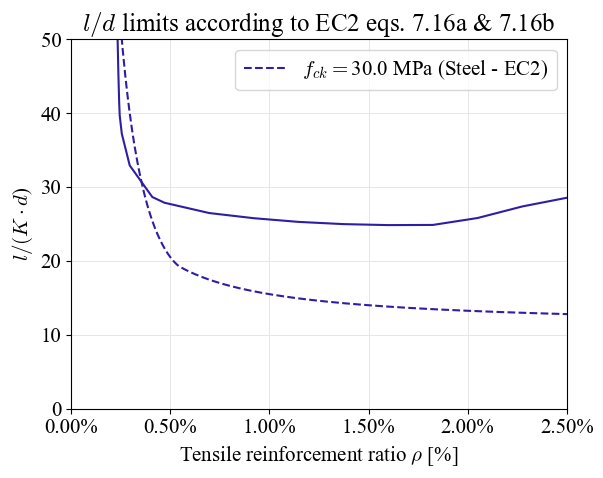

In [19]:
fig, ax = plt.subplots()

color = np.random.rand(3, )

# cs = ax.contour(rho, sl, z1, levels=[0], colors=[color])
# cs = ax.contour(rho, sl, z2, levels=[0], colors=[color])
# cs = ax.contour(rho, sl, z3, levels=[0.2, 0.4, 0.6, 0.8, 1], colors=[color])
# cs = ax.contour(rho, sl, 1/z3, levels=[0.2, 0.4, 0.6, 0.8, 1])

# cs = ax.contour(rho, sl, z4, levels=[0], colors=[color])

# cs = ax.contour(rho, sl, z5, levels=[0], colors=[color])

# cs = ax.contour(rho, sl, z6, levels=[0], colors=[color])

                
# cs = ax.contour(rho, sl, z3, levels=1 - util_levels, colors=[color])

# cs = ax.contour(rho, sl, z)
# cs.collections[0].set_label(label)

# Put values on lines
# ax.clabel(cs, inline=True, fontsize=10)

# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# b_sls.rho = v[:, 0]
# b_sls.sl = v[:, 1]

# Draw EC2 curve
b_sls.plot_steel_sls_curves(ax, f_cks=[b_sls.f_ck],
                           axes_start_from_zero=True,
                           color=color)
# print(np.min(z), np.max(z))
fig

$$
\eta^\mathrm{FRP} = \frac{F^\mathrm{FRP}_\mathrm{C}}{F^\mathrm{FRP}_\mathrm{Ek,qp}}
$$

$$
\eta^\mathrm{steel} = \frac{F^\mathrm{steel}_\mathrm{C}}{F^\mathrm{steel}_\mathrm{Ek,qp}}
$$

$$
\eta = \frac{F^\mathrm{FRP}_\mathrm{C}}{F^\mathrm{steel}_\mathrm{C}}
$$

In [ ]:
EC2.get_f_ctm_fl(b_sls.f_ck, 300)

Parametric study is running...
f_ck: (30), parameter combination 0.0002 3.0
parameter combination 0.0002 5.9375
parameter combination 0.0002 8.875
parameter combination 0.0002 11.8125
parameter combination 0.0002 14.75
parameter combination 0.0002 26.5
parameter combination 0.0002 38.25
parameter combination 0.0002 50.0
parameter combination 0.0017500000000000003 3.0
parameter combination 0.0017500000000000003 5.9375
parameter combination 0.0017500000000000003 8.875
parameter combination 0.0017500000000000003 11.8125
parameter combination 0.0017500000000000003 14.75
parameter combination 0.0017500000000000003 26.5
parameter combination 0.0017500000000000003 38.25
parameter combination 0.0017500000000000003 50.0
parameter combination 0.0033000000000000004 3.0
parameter combination 0.0033000000000000004 5.9375
parameter combination 0.0033000000000000004 8.875
parameter combination 0.0033000000000000004 11.8125
parameter combination 0.0033000000000000004 14.75
parameter combination 0.0033

parameter combination 0.0033000000000000004 5.9375
parameter combination 0.0033000000000000004 8.875
parameter combination 0.0033000000000000004 11.8125
parameter combination 0.0033000000000000004 14.75
parameter combination 0.0033000000000000004 26.5
parameter combination 0.0033000000000000004 38.25
parameter combination 0.0033000000000000004 50.0
parameter combination 0.00485 3.0
parameter combination 0.00485 5.9375
parameter combination 0.00485 8.875
parameter combination 0.00485 11.8125
parameter combination 0.00485 14.75
parameter combination 0.00485 26.5
parameter combination 0.00485 38.25
parameter combination 0.00485 50.0
parameter combination 0.0064 3.0
parameter combination 0.0064 5.9375
parameter combination 0.0064 8.875
parameter combination 0.0064 11.8125
parameter combination 0.0064 14.75
parameter combination 0.0064 26.5
parameter combination 0.0064 38.25
parameter combination 0.0064 50.0
parameter combination 0.0126 3.0
parameter combination 0.0126 5.9375
parameter comb

<lambdifygenerated-117>:2: RuntimeWarning: invalid value encountered in power
  return -select([less(eps, varepsilon_cu),less(eps, varepsilon_cy),less(eps, 0),less(eps, varepsilon_cr),less(eps, varepsilon_tu),True], [0,f_cd,f_cd*(1 - (-eps/varepsilon_cy + 1)**n),-E_ct*eps,-E_ct*mu*varepsilon_cr,0], default=nan)


parameter combination 0.00485 5.9375
parameter combination 0.00485 8.875
parameter combination 0.00485 11.8125
parameter combination 0.00485 14.75
parameter combination 0.00485 26.5
parameter combination 0.00485 38.25
parameter combination 0.00485 50.0
parameter combination 0.0064 3.0
parameter combination 0.0064 5.9375
parameter combination 0.0064 8.875
parameter combination 0.0064 11.8125
parameter combination 0.0064 14.75
parameter combination 0.0064 26.5
parameter combination 0.0064 38.25
parameter combination 0.0064 50.0
parameter combination 0.0126 3.0
parameter combination 0.0126 5.9375
parameter combination 0.0126 8.875
parameter combination 0.0126 11.8125
parameter combination 0.0126 14.75
parameter combination 0.0126 26.5
parameter combination 0.0126 38.25
parameter combination 0.0126 50.0
parameter combination 0.0188 3.0
parameter combination 0.0188 5.9375
parameter combination 0.0188 8.875
parameter combination 0.0188 11.8125
parameter combination 0.0188 14.75
parameter com

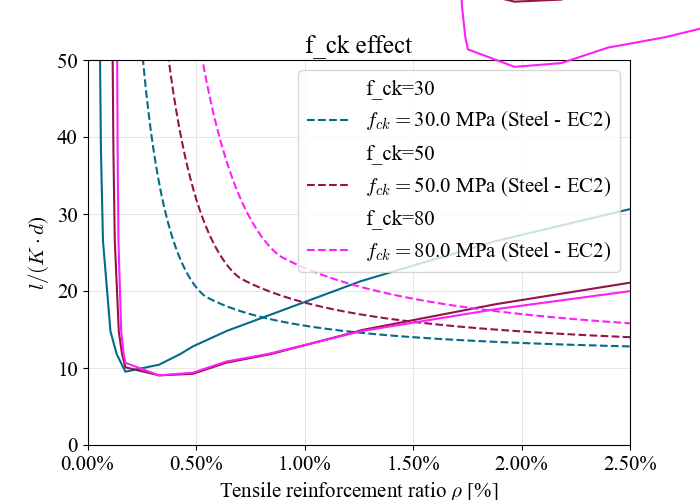

In [7]:
ps = SLSParamStudy(b_sls)
params_config = [
#     ['f_ctm', b_sls, [1* EC2.get_f_ctm_fl(b_sls.f_ck, 300), 2* EC2.get_f_ctm_fl(b_sls.f_ck, 300)]],
#     ['f_ctm', b_sls, [0, 2, 5]],
#     [['f_ck', b_sls, [30, 50, 70]], ['f_ctm', b_sls, [7.5, 10.58, 12]]],
#         [['f_ck', b_sls, [10]], ['f_ctm', b_sls, [4]]],
    ['f_ck', b_sls, [30, 50, 80]],
#     ['sls_to_uls_ratio', b_sls, [0.59, 0.51]]
#     ['concrete_law', b_sls, ['EC2 with plateau', 'EC2']],
#     ['n_i', b_sls, [30]],
#     ['dense_quarter', b_sls, [True, False]],
#     ['use_f_ctm_fl', b_sls, [True, False]],
#     ['apply_material_factors', b_sls, [True, False]],
#     ['rein_type', b_sls, ['carbon_grid', 'carbon_rebars']],
#     ['H', b_sls.dp.mc.cross_section_shape_, [200, 400, 600]],
#     ['B', b_sls.dp.mc.cross_section_shape_, [1000, 200]],
#     [['B', b_sls.dp.mc.cross_section_shape_, [1000, 200, 300]], ['H', b_sls.dp.mc.cross_section_shape_, [300, 400, 700]]],
#     [['f_t', b_sls.dp.mc.cross_section_layout.items[0].matmod_, [1000]], ['E', b_sls.dp.mc.cross_section_layout.items[0].matmod_, [100000]]],
    ]
fig = ps.run(params_config, savefig=True)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
b_sls.dp.plot_fw_with_fmax(ax)
# fig.savefig('carbon_sl_10_rho_0.28.pdf')
fig

In [ ]:
# sls.plot_F_u()
sls.plot_F_u(bending_shear_diff = True)
# sls.plot_F_u(load='shear')


# Achse x: Bewehrungsgrad rho [%]
# Achse y: Biegeschlankheit l/d [-]

## Tensile vs compression failure zones

In [ ]:
dp = b_sls.dp
mc = dp.mc
# for rho in b_sls.rho_range:
#     area_g = mc.cross_section_shape_.get_cs_area()
#     A_j_g = rho * area_g
#     mc.cross_section_layout.items[0].A = A_j_g
#     mc.M_t / mc.M_scale

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(b_sls.rho_grid, b_sls.sl_grid, b_sls.F_u_grid,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)

In [ ]:
np.linspace(0, 5000, 30)
fig, ax = plt.subplots()
# z = b_sls.F_u_grid / b_sls.F_s_grid - 1. / b_sls.sls_to_uls_ratio
z = b_sls.F_u_grid
cs = ax.contour(b_sls.rho_grid, b_sls.sl_grid, z, levels=[0, 10, 20, 50, 80, 100, 150, 300, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax.clabel(cs, inline=True, fontsize=10)

### 1. EC2 - Steel

In [ ]:
b_sls.n_i = 10
b_sls.rein_type = 'steel'
b_sls.dense_quarter = False

### 2. EC2 - Carbon

In [ ]:
b_sls.n_i = 10
b_sls.rein_type = 'carbon_grid'
b_sls.dense_quarter = True